# Курсовой проект для курса "Python для Data Science"

#### Задание:
Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

#### Целевая переменная:
Price

#### Метрика качества:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

#### Требования к решению:
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

#### Рекомендации для файла с кодом (ipynb):
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.


#### Описание датасета:
Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [2]:
TEST_DATASET_PATH = "test.csv"
TRAIN_DATASET_PATH = "train.csv"

In [3]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


#### Уменьшаем объем данных

In [4]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
df = reduce_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

### Оценим имеющиеся данные

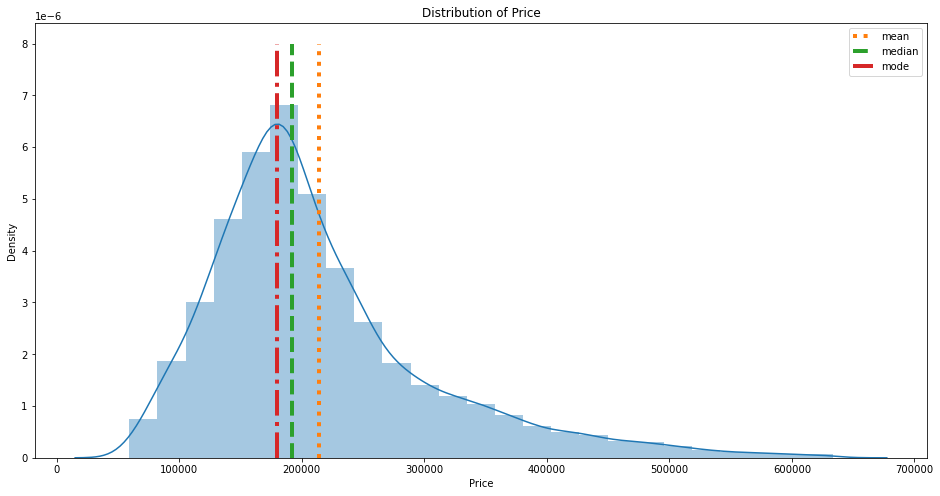

In [6]:
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=25)

y = np.linspace(0, 0.000008, 10)
plt.plot([df['Price'].mean()] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([df['Price'].median()] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([df['Price'].mode()[0] // 10000 * 10000] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

Среднее значение немного смещено изза ассиметрии в право, однако мода и медиана достаточно близко, и в целом мы видим нормально распределение. Длина хвоста говорит нам, что сильно дорогих кавртир на много больше сильно дешевых.

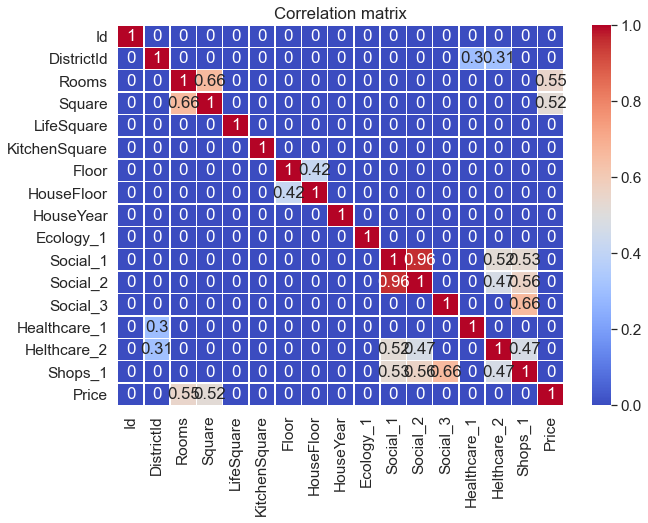

In [7]:
plt.figure(figsize = (10,7))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

#### Разбиваем на трейн и тест

In [8]:
X_train, y_train = df.drop("Price", axis = 1), df["Price"]

In [9]:
X_test = pd.read_csv(TEST_DATASET_PATH)
IKurkov_predictions = pd.DataFrame(X_test['Id']) # для того, чтоб потом можно было получить ID, Price для выгрузки ответов. 

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=47)

In [11]:
X_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,7000.000000,7000.000000,7000.000000,7000.000000,5514.000000,7000.000000,7000.000000,7000.000000,7.000000e+03,7000.000000,7000.000000,7000.000000,7000.000000,3622.000000,7000.000000,7000.000000
mean,8355.944429,50.380286,1.890857,56.349125,36.334522,6.431143,8.465857,12.551143,4.849407e+03,0.118864,24.799000,5384.084286,8.007000,1164.085327,1.319286,4.228714
std,4859.364585,43.750859,0.850480,21.555962,20.853006,33.960041,5.200314,6.739928,2.396436e+05,0.118758,17.631259,4036.855151,23.562797,1037.780518,1.491194,4.780312
min,0.000000,0.000000,0.000000,1.988943,0.641822,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,4179.750000,20.000000,1.000000,41.784348,22.726414,1.000000,4.000000,9.000000,1.973000e+03,0.019509,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8344.000000,35.000000,2.000000,52.413246,32.810188,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5288.000000,2.000000,990.000000,1.000000,3.000000
75%,12541.750000,75.000000,2.000000,65.981638,45.099518,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000
max,16798.000000,209.000000,19.000000,641.065186,638.163208,2014.000000,33.000000,99.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


##### Первый взгляд на данные.
- Id можно исключить из анализа, т.к. он не несет полезной информации, только индекс. Или использовать вместо индекса строк.
- District т.к. это скорее категориальное значение можно заменить модой
- Rooms 0 врядли верное значение, даже студия считается минимум 1 комнатой. Можно высчитать среднюю площадь на комнату из имеющихся данных и вставлять в 0 значения Lifesquare / среднее площадь и округлить до целого. Также стоит проверить максимальное значеие комнат.
- Square минимальная и максимальная площадь подозрительны
- LifeSquare  также минимальная и максимальное значение подозрительны.
- KitchenSquare таже история с максимальным. 
- Floor вроде все ок, разве что проверить максимальное значение..
- HouseFloor 0 этажей не может быть. 
- HouseYear перевести год постройки в возвраст дома.
- Ecology_1	Social_1	Social_2	Social_3	Healthcare_1	Helthcare_2	Shops_1 не понятно, что за показатели, так что нужно посмотреть в первую очередь, как можно заполнить НаН значения.



#### Id

In [12]:
X_train = X_train.drop('Id', axis=1)

Уберем признак, т.к. он не информатьивен.

#### DistrictId

In [13]:
X_train['DistrictId'].value_counts()

27     609
1      459
23     396
6      351
9      204
      ... 
181      1
117      1
196      1
112      1
207      1
Name: DistrictId, Length: 205, dtype: int64

В целом наблюдения похожи, так что скорее всего 0 это не выброс, а счет идет с 0 включительно. Т.к. этот признак номинальный, надо его привести к количественному. Как вариант, нормализовать по доли. Таким образом, мы номер района превратим в индекс популярности.

In [14]:
distict_dict = X_train["DistrictId"].value_counts(normalize=True).to_dict()

In [15]:
X_train.replace({"DistrictId": distict_dict}, inplace=True )

In [16]:
X_train["DistrictId"].value_counts()

0.087000    609
0.065571    459
0.056571    396
0.050143    351
0.029143    204
           ... 
0.003000     21
0.002857     20
0.002714     19
0.000286     14
0.000143     11
Name: DistrictId, Length: 75, dtype: int64

#### Rooms

In [17]:
X_train['Rooms'].value_counts()

2.0     2724
1.0     2590
3.0     1555
4.0      107
5.0       12
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Хоть по статистике и получается, что 4 и более комнат являются выбросами, но после просмотра данных по этим квартирам становится ясно, что 4 комнаты, это просто большие квартиры, а выбросы это  5 и более комнат.
По этому обработаем выбросы, заменив на ближайшее нормальное значение, и создадим доп признак для выделения изменения.  

In [18]:
X_train["Rooms_outlier"] = 0
X_train.loc[(X_train["Rooms"] >= 5), "Rooms_outlier"] = 1
X_train.loc[(X_train["Rooms"] >= 5), "Rooms"] = 4


#### KitchenSquare

In [19]:
X_train.loc[X_train["KitchenSquare"] > 150, "KitchenSquare"] = X_train["KitchenSquare"].median() # отсечем явно ошибочные значения

#### LifeSquare

Заполняя Нан значения средним или медианой по признаку, получается большой перекос, т.к. пропущенных значений слишком много.  Мы можем расчитать средний коэффициент отношения жилой площади к общей площади, и используя его спрогнозировать пропущенные значения.

In [20]:
X_train["LifeSquare_nan"] = 0
X_train.loc[X_train["LifeSquare"].isnull(), "LifeSquare_nan"] = 1

In [21]:
life_square_coef =  X_train["LifeSquare"].mean() / X_train["Square"].mean()
X_train.loc[X_train["LifeSquare"].isnull(), "LifeSquare"] = X_train.loc[X_train["LifeSquare"].isnull(), "Square"] * life_square_coef

#### Floor

Как правило первый и последний этажи стоят дешевле, можно это пометить.


In [22]:
bad_floor = (X_train["Floor"] == 1) | (X_train["Floor"] == X_train["HouseFloor"])
X_train["Bad_floor"] = 0
X_train.loc[bad_floor, "Bad_floor"] = 1

#### HouseFloor	

In [23]:
X_train.loc[X_train["HouseFloor"] == 0].head(5) # 0 этажей явно ошибка

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Rooms_outlier,LifeSquare_nan,Bad_floor
3911,0.008429,0.0,49.483501,31.907494,0.0,16,0.0,2015,0.118537,B,...,30,6207,1,1183.0,1,0,B,0,1,0
7918,0.003000,2.0,48.148067,31.046391,0.0,6,0.0,1977,0.236108,B,...,16,3893,27,NaN,3,10,B,0,1,0
2191,0.008714,3.0,98.994911,63.832981,0.0,3,0.0,1977,0.041125,B,...,46,9515,5,NaN,1,10,B,0,1,0
8108,0.026000,1.0,46.416927,29.930134,0.0,8,0.0,1977,0.072158,B,...,2,629,1,NaN,0,0,A,0,1,0
6161,0.087000,1.0,51.018288,22.370991,0.0,4,0.0,2016,0.017647,B,...,2,469,0,NaN,0,0,B,0,0,0


Заменим 0 этажи значением этажа продаваемой квартиры.

In [24]:
X_train["HouseFloor_outlier"] = 0
X_train.loc[X_train["HouseFloor"] == 0, "HouseFloor_outlier"] = 1
X_train.loc[X_train["HouseFloor"] == 0, "HouseFloor"] = X_train.loc[X_train["HouseFloor"] == 0, "Floor"]

#### HouseYear

Переведем год постройки в возраст дома.

In [25]:
from datetime import datetime
x = datetime.now()
X_train.loc[X_train["HouseYear"] > x.year, "HouseYear"] = X_train["HouseYear"].median()
X_train["HouseYear"] = x.year - X_train["HouseYear"]


<AxesSubplot:>

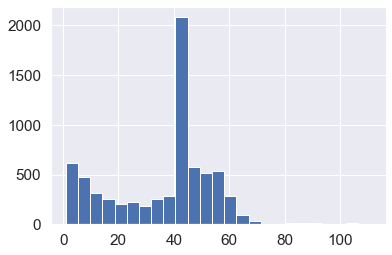

In [26]:
X_train["HouseYear"].hist(bins=25)

In [27]:
X_train["HouseYear"].value_counts()

44     1846
5       226
6       216
4       211
7       145
       ... 
81        1
89        1
93        1
107       1
111       1
Name: HouseYear, Length: 95, dtype: int64

Явно выделяются дома которым 44 года.

In [28]:
X_train['Ecology_2'] = (X_train['Ecology_2'] == 'A').astype(int)
X_train['Ecology_3'] = (X_train['Ecology_3'] == 'A').astype(int)
X_train['Shops_2'] = (X_train['Shops_2'] == 'A').astype(int)

#### Healthcare_1 

--- Начало Healthcare_1 ---

Спрогнозируем Нан значения через модель.

In [29]:
X_train_H = X_train.loc[X_train['Healthcare_1'].notnull()]
y_2 = X_train_H["Healthcare_1"]
X_train_H = X_train_H.drop(['Healthcare_1'], axis = 1)

In [30]:
gb_model2 = GradientBoostingRegressor(criterion='mse', min_samples_leaf=10, random_state=42, max_depth = 5, max_features=6, n_estimators=200)
gb_model2.fit(X_train_H, y_2)

GradientBoostingRegressor(criterion='mse', max_depth=5, max_features=6,
                          min_samples_leaf=10, n_estimators=200,
                          random_state=42)

In [31]:
X_nan_healthcare_1 = (X_train.loc[X_train['Healthcare_1'].isnull()]).drop('Healthcare_1', axis = 1)
y_pred_healthcare_1 = gb_model2.predict(X_nan_healthcare_1)
X_train.loc[X_train['Healthcare_1'].isnull(), 'Healthcare_1'] = y_pred_healthcare_1

--- Конец Healthcare_1 ---

### Подготавливаем тестовый сет

In [32]:

medians = X_train["KitchenSquare"].median(), X_train["HouseYear"].median()

In [33]:
def x_test_prepare(X_test_prepare, medians):

    
    kitchenSquare, houseyear = medians
    
    X_test_prepare = X_test_prepare.drop('Id', axis=1)
    X_test_prepare.replace({"DistrictId": distict_dict}, inplace=True )
   
    X_test_prepare["Rooms_outlier"] = 0
    X_test_prepare.loc[(X_test_prepare["Rooms"] >= 5), "Rooms_outlier"] = 1
    X_test_prepare.loc[(X_test_prepare["Rooms"] >= 5), "Rooms"] = 4
    
    X_test_prepare.loc[X_test_prepare["KitchenSquare"] > 150, "KitchenSquare"] = kitchenSquare
    
    
    X_test_prepare["LifeSquare_nan"] = 0
    X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "LifeSquare_nan"] = 1
    X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "LifeSquare"] = X_test_prepare.loc[X_test_prepare["LifeSquare"].isnull(), "Square"] * life_square_coef
    
    X_test_bad_floor = (X_test_prepare["Floor"] == 1) | (X_test_prepare["Floor"] == X_test_prepare["HouseFloor"])
    X_test_prepare["Bad_floor"] = 0
    X_test_prepare.loc[X_test_bad_floor, "Bad_floor"] = 1
    

    X_test_prepare["HouseFloor_outlier"] = 0
    X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "HouseFloor_outlier"] = 1
    X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "HouseFloor"] = X_test_prepare.loc[X_test_prepare["HouseFloor"] == 0, "Floor"]
    
    x = datetime.now()
    X_test_prepare.loc[X_test_prepare["HouseYear"] > x.year, "HouseYear"] = houseyear
    X_test_prepare["HouseYear"] = x.year - X_test_prepare["HouseYear"]
    
    
    X_test_prepare['Ecology_2'] = (X_test_prepare['Ecology_2'] == 'A').astype(int)
    X_test_prepare['Ecology_3'] = (X_test_prepare['Ecology_3'] == 'A').astype(int)
    X_test_prepare['Shops_2'] = (X_test_prepare['Shops_2'] == 'A').astype(int) 
    
    
    X_nan_healthcare_1 = (X_test_prepare.loc[X_test_prepare['Healthcare_1'].isnull()]).drop('Healthcare_1', axis = 1)
    y_pred_healthcare_1 = gb_model2.predict(X_nan_healthcare_1)
    X_test_prepare.loc[X_test_prepare['Healthcare_1'].isnull(), 'Healthcare_1'] = y_pred_healthcare_1
    
   
    return X_test_prepare

In [34]:
X_test = x_test_prepare(X_test, medians)

In [35]:
X_valid = x_test_prepare(X_valid, medians)

### Обучаем модель

Подбор гиперпараметров

#### Финальная модель

In [36]:
gb_model = GradientBoostingRegressor(criterion='mse', min_samples_leaf=10, random_state=42, max_depth = 6, max_features=5, n_estimators=200)

In [37]:
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', max_depth=6, max_features=5,
                          min_samples_leaf=10, n_estimators=200,
                          random_state=42)

In [49]:
y_pred = gb_model.predict(X_valid)
y_pred = gb_model.predict(X_valid)

In [39]:
def evaluate_preds(true_values, pred_values, save=False):
        
    print("R2:\t" + str(round(r2(true_values, pred_values), 4)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    plt.show()

### Итоговый результат

R2:	0.7623
RMSE:	45058.711
MSE:	2030287464.095


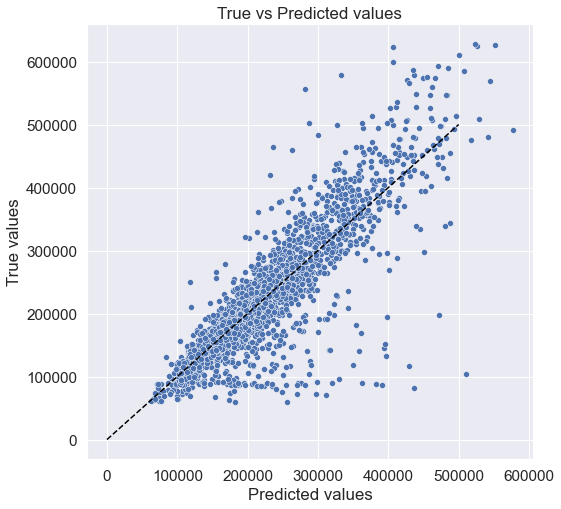

In [50]:
evaluate_preds(y_valid, y_pred)


In [41]:
f_i = gb_model.feature_importances_

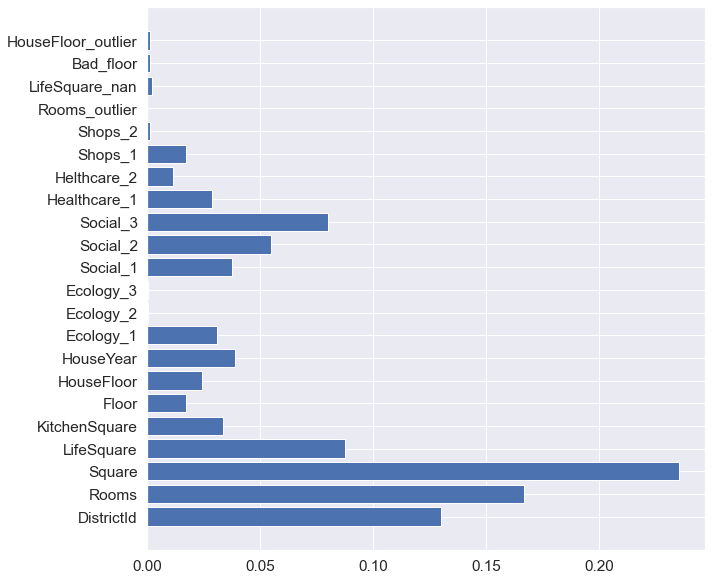

In [42]:
plt.figure(figsize=(10,10))
plt.barh(X_train.columns, f_i)
plt.show()

Манипуляции с DistrictId, Healthcare_1, LifeSquare оправдались, получились сильные признаки.

In [43]:
y_test_pred = gb_model.predict(X_test)

In [44]:
IKurkov_predictions["Price"] = y_test_pred

In [45]:
IKurkov_predictions

,Id,Price
0,725,155069.286584
1,15856,227183.750654
2,5480,310791.338868
3,15664,336001.752947
4,14275,140844.766014
...,...,...
4995,8180,246617.976090
4996,4695,129597.102626
4997,5783,363924.234246
4998,4780,190735.883377
